### **CLIP-I, CLIP-T, DINO**

- **CLIP-I** - average pairwise cosine similarity between CLIP embeddings of generated and real images
- **CLIP-T** - average cosine similarity between prompt and CLIP embeddings of generated images
- **DINO** - average pairwise cosine similarity between the Vit-S/16 DINO embeddings of generated and real images

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.nn import functional as F
from transformers import AutoModel, AutoProcessor, AutoTokenizer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [3]:
img_path_1 = '/net/tscratch/people/plgkzaleska/ziplora-analysis/data/dreambooth/dataset/rc_car/01.jpg'
img_path_2 = '/net/tscratch/people/plgkzaleska/ziplora-analysis/data/dreambooth/dataset/rc_car/02.jpg'
img_path_3 = '/net/tscratch/people/plgkzaleska/ziplora-analysis/data/dreambooth/dataset/rc_car/03.jpg'

In [4]:
image1 = Image.open(img_path_1)
image2 = Image.open(img_path_2)
image3 = Image.open(img_path_3)

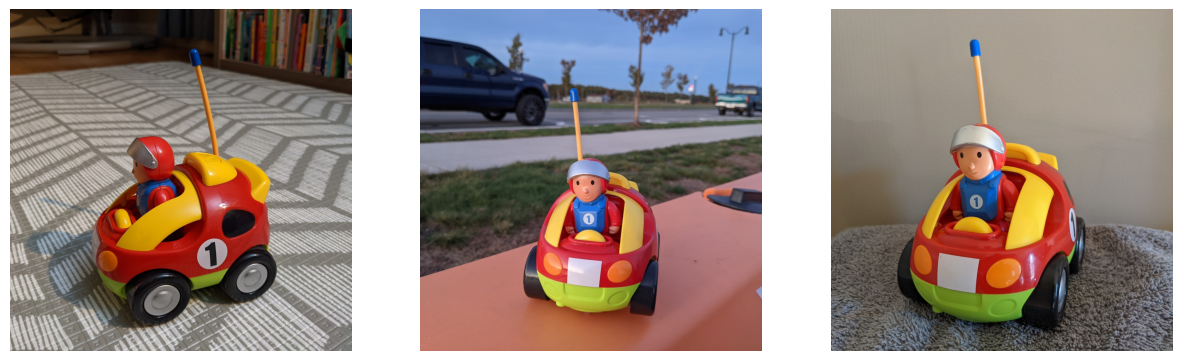

In [5]:
# display images in figure
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(image3)
# hide the axes
for ax in ax:
    ax.axis('off')
plt.show()

#### **CLIP-I**

In [6]:
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = AutoModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

In [7]:
inputs1 = clip_processor(images=image1, return_tensors="pt").to(device)
image_features1 = clip_model.get_image_features(**inputs1)

inputs2 = clip_processor(images=image2, return_tensors="pt").to(device)
image_features2 = clip_model.get_image_features(**inputs2)

In [8]:
sim = F.cosine_similarity(image_features1[0], image_features2[0], dim=0)
print(f"Similarity: {sim.item():.3f}")

Similarity: 0.732


#### **CLIP-T**

In [9]:
clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [10]:
input_text = "a photo of a toy car"
text = clip_tokenizer(input_text, return_tensors="pt", padding=True).to(device)

In [11]:
input_img = clip_processor(images=image1, return_tensors="pt").to(device)

In [12]:
img_embeddings = clip_model.get_image_features(**input_img)
text_features = clip_model.get_text_features(**text)

In [13]:
sim = F.cosine_similarity(img_embeddings[0], text_features[0], dim=0)
print(f"Similarity: {sim.item():.3f}")

Similarity: 0.308


#### **DINO**

In [14]:
dino_model = AutoModel.from_pretrained("facebook/dino-vits16", add_pooling_layer=False).to(device)

In [15]:
T = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [16]:
# get DINO features
inputs1 = T(image1).unsqueeze(0).to(device)
image_features1 = dino_model(inputs1).last_hidden_state

inputs2 = T(image2).unsqueeze(0).to(device)
image_features2 = dino_model(inputs2).last_hidden_state

In [17]:
sim = F.cosine_similarity(image_features1[0, 0], image_features2[0, 0], dim=0)
print('Similarity:', sim.item())

Similarity: 0.5891121625900269


#### **Compare with multiple references**

In [18]:
from lora.metrics import clip_text_metric, clip_image_metric, dino_metric

In [19]:
clip_image_metric(img_path_1, [img_path_2, img_path_3])

0.7880731821060181

In [20]:
clip_text_metric(img_path_1, ["a photo of a toy car", "a photo of a toy car", "car toy"])

0.3041876256465912

In [21]:
dino_metric(img_path_1, [img_path_2, img_path_3])

0.6432802081108093